# Домашнее задание 2

**Ломакин Н.А MADE-ML-21**

В спортивном “Что? Где? Когда?” соревнующиеся команды отвечают на одни и те же вопросы. После минуты обсуждения команды записывают и сдают свои ответы на карточках; побеждает тот, кто ответил на большее число вопросов. Турнир обычно состоит из нескольких десятков вопросов (обычно 36 или 45, иногда 60, больше редко). Часто бывают синхронные турниры, когда на одни и те же вопросы отвечают команды на сотнях игровых площадок по всему миру, т.е. в одном турнире могут играть сотни, а то и тысячи команд. Соответственно, нам нужно:

* построить рейтинг-лист, который способен нетривиально предсказывать результаты будущих турниров;
* при этом, поскольку ЧГК — это хобби, и контрактов тут никаких нет, игроки постоянно переходят из команды в команду, сильный игрок может на один турнир сесть поиграть за другую команду и т.д.; поэтому единицей рейтинг-листа должна быть не команда, а отдельный игрок;
* а что сильно упрощает задачу и переводит её в область домашних заданий на EM-алгоритм — это характер данных: начиная с какого-то момента, в базу результатов начали вносить все повопросные результаты команд, т.е. в данных будут записи вида “какая команда на какой вопрос правильно ответила”.

## Пункт 1
Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
* взять в тренировочный набор турниры с dateStart из 2019 года; 
* в тестовый — турниры с dateStart из 2020 года.

In [38]:
%matplotlib inline
import numpy as np
import json, pickle
from datetime import timedelta, datetime
import dateutil.parser
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import lil_matrix, vstack
from sklearn.linear_model import LogisticRegression
import math
from scipy.stats import spearmanr, kendalltau
from collections import defaultdict, Counter
from scipy.special import expit, logit

In [2]:
tournaments = pickle.load(open('tournaments.pkl', 'rb'))
results = pickle.load(open('results.pkl', 'rb'))
players = pickle.load(open('players.pkl', 'rb'))

dict results имеет следующую структуру внутри себя:

```
0: team

1: mask

2: current

3: questionsTotal

4: synchRequest

5: position

6: controversials

7: flags

8: teamMembers
```



players имеет структуру:

```id	name	patronymic	surname```

tournaments имеет структуру:

```id	name	dateStart	dateEnd	type	season	orgcommittee	synchData	questionQty```

In [3]:
date_2019_begin = datetime.strptime("2019-01-01", "%Y-%m-%d")
date_2020_begin = datetime.strptime("2020-01-01", "%Y-%m-%d")

tournaments_2019 = []
tournaments_2020 = []

for key in tournaments.keys():
    t_dateStart = datetime.fromisoformat(tournaments[key]["dateStart"]).replace(
        tzinfo=None
    )
    # скипаем все даты до 2019 года
    if t_dateStart >= date_2019_begin:
        # скипаем если в резалте нет команд
        if not results[key]:
            continue

        # не будем учитывать турниры, в которых у команд разные маски ответов.
        accamulate_question_len = set()
        for team in results[key]:
            if team.get("mask") is not None:
                accamulate_question_len.add(len(team["mask"]))
        if len(accamulate_question_len) > 1:
            continue

        # теперь отформатируем данные для турниров
        tournament = dict()
        tournament["id"] = tournaments[key]["id"]
        tournament["teams"] = []

        for team in results[key]:
            # скипнем команды с непонятными символами в ответах, или с пустыми ответами
            if team.get("mask") is None or team.get("mask").replace("1", "").replace(
                "0", ""
            ):
                continue

            cell_team = dict()
            cell_team["id"] = team["team"]["id"]
            cell_team["members"] = []
            cell_team["mask"] = team["mask"]

            for member in team["teamMembers"]:
                cell_team["members"].append(member["player"]["id"])

            tournament["teams"].append(cell_team)

        if not tournament["teams"]:
            continue

        if t_dateStart < date_2020_begin:
            tournaments_2019.append(tournament)
        else:
            tournaments_2020.append(tournament)

Данные более менее обработаны, теперь можно глянуть на статистики:

In [4]:
members = set()
answer_count = defaultdict(int)
right_answer_count = defaultdict(int)


for tournament in tournaments_2019:
    tournament_answers = []
    for team in tournament['teams']:
        for member in team['members']:
            answer_count[member] += len(team['mask'])
            right_answer_count[member] = sum(list(map(int, team['mask'])))
            members.add(member)


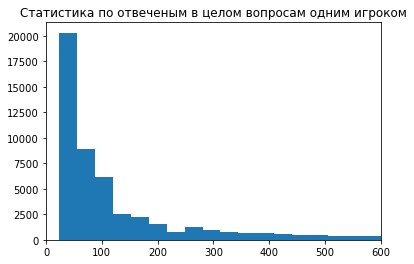

In [5]:
plt.hist(answer_count.values(), bins=220);
plt.title('Статистика по отвеченым в целом вопросам одним игроком')
plt.xlim(xmin=0.0, xmax = 600)
#plt.ylim(ymin=0.0, ymax = 80000)
plt.show();

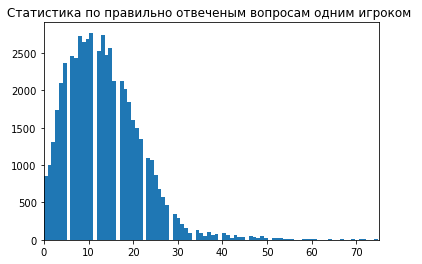

In [6]:
plt.hist(right_answer_count.values(), bins=220);
plt.xlim(xmin=0.0, xmax = 75)
plt.title('Статистика по правильно отвеченым вопросам одним игроком ')
plt.show();

In [7]:
len(tournaments_2019), len(tournaments_2020)

(604, 156)

In [8]:
len(answer_count)

55151

## Пункт 2
Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
* повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
* в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
* для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.

Всего i шгроков, \
$S_i$ - cила  $i-ого$  игрока \
$q_j$ - сложность $о-ого$  вопроса \
$\mu$ - глобальное среднее  
$p(x | s_{i},q_{j})=\sigma(s_i-q_j + \mu)$ - вероятность ответа i-ого игрока на j-тый вопрос 

Получается у нас модель логистической регрессии с разреженой матрицей признаков

In [9]:
questions_count = 0

for tournament in tournaments_2019:
    questions_count += len(tournament['teams'][0]['mask'])
    

In [10]:
questions_count = 0

for tournament in tournaments_2019:
    questions_count += len(tournament['teams'][0]['mask'])
    
cols = len(members) + questions_count

rows = 0
for tournament in tournaments_2019:
    for team in tournament['teams']:
        rows += len(team['members'])*len(team['mask'])

id_idx_dict = {id : idx for idx, id in enumerate(sorted(list(members)))}

In [11]:
# player_id2number

In [12]:
X = lil_matrix((rows, cols), dtype=np.int8)
y = np.zeros(rows)

In [13]:
idx_shift = len(members)
row_number = 0

for tournament in tournaments_2019:
    for team in tournament['teams']:
        for i in range(len(team['mask'])):
            y_ans = int(team['mask'][i])
            question_idx = idx_shift + i
            for player_id in team['members']:
                X[row_number, id_idx_dict[player_id]] = 1
                X[row_number, question_idx] = -1
                y[row_number] = y_ans
                row_number += 1
    idx_shift += len(tournament['teams'][0]['mask'])

In [14]:
lr = LogisticRegression(solver='saga', C=1)
lr.fit(X, y);

In [15]:

# Получаем "силу" игроков и сложность вопросов
S, q = lr.coef_[0][:len(members)], lr.coef_[0][len(members):] - lr.intercept_

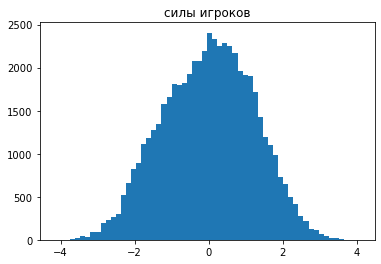

In [16]:
plt.hist(S, bins=60);
plt.title('силы игроков');

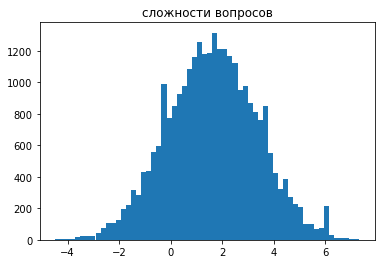

In [17]:
plt.title('сложности вопросов');
plt.hist(q, bins=60);

По гистограммам, эти распределения походи на нормальные. Так теперь и будем считать.

## Пункт 3

Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
* предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
* в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.

(Для самопроверки: у меня средняя корреляция Спирмена на тестовом множестве 2020 года во всех моделях, включая baselines, получалась порядка 0.7-0.8, а корреляция Кендалла — порядка 0.5-0.6. Если у вас корреляции вышли за 0.9 или, наоборот, упали ниже 0.3, скорее всего где-то баг.)

---

Итак, исходя из условий мы знаем силы игроков ($S_i$) и при этом не знаем насколько сложные вопросы на которые они отвечают. \
В этом случае вероятность правильного ответа - мат. ожидание по распределению сложности вопросов:
$$
p_i = \mathbb{E}_{q}[p_{ij}] = \int \sigma(s_{i} - q)p(q)dq
$$

Из нашего предположения сложность вопросов имеет нормальное распределение с дисперсией $\sigma^2_{q}$ и среднем $\mu_{q}$. При вычислении интеграла приближенно заменяем сигмоиду пробитом и получаем такую фурмулу:
$$
p_{i} \approx 
\sigma \left (
\frac {s_{i} - \mu_{q}}
{\sqrt{1 + \frac{\pi}{8} \sigma^{2}_{q}}}
\right )
$$

В случае, если же игрок не играл в 2019 году и мы не знаем его силу, то будем считать что этот игрок средний, и его средние параметры так же взяты из нормального распределения, график которого строили в предыдущем пункте. 

Вероятность того что вся команда ответила правильно считаем вот так вот:
$$
p_{c} = 1 - \prod (1 - p_{i})
$$


Напишем функцию для расчета метирик качества (Спирмена и Кендалла) так как будем использовать их и в следующих шагах.

In [18]:
def get_correlations(S, q):
    p_p = {}
    spearman = []
    kendall = []
    
    for id in sorted(list(members)):
        p_p[id] = expit((S[id_idx_dict[id]] - q.mean()) / math.sqrt(1 + math.pi / 8 * q.var()))

    p_p_default = expit((S.mean() - q.mean()) / math.sqrt(1 + math.pi / 8 * (S.var() + q.var())))

    
    for tournament in tournaments_2020:
        result = results[tournament['id']]
        
        if len(result) <= 1:
            continue
            
        strength_from_result = []
        strength_predicted = []
        
        for team in result:
            strength_from_result.append(team['questionsTotal'])
            p_ids = [p['player']['id'] for p in team['teamMembers']]
            p = np.asarray([p_p.get(idx, p_p_default) for idx in p_ids])
            strength_predicted.append(1 - (1 - p).prod())
            
        kendall.append(kendalltau(strength_from_result, strength_predicted).correlation)
        spearman.append(spearmanr(strength_from_result, strength_predicted).correlation)
        
    return np.mean(kendall), np.mean(spearman)


In [19]:
kendall, spearman = get_correlations(S, q)

print('Корреляция Спирмена: ', spearman)
print('Корреляция Кендалла: ', kendall)

Корреляция Спирмена:  0.7400977466465982
Корреляция Кендалла:  0.5840406394216385


Полученые корреляции проходят условия сампороверки из условия задачки ^_^

---

## Пункт 4

Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:

* предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
* разработайте EM-схему для обучения этой модели, реализуйте её в коде;
* обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.



В базовой модели бы предпологали что ответ команды относится ко всем участникам команды.
Но на самом деле мы не знаем какой игрок (или игроки) ответили верно.
Всё что мы можем предположить, это что  если команда ответила неверно, то никто из команды не ответил верно. \
И сейчас мы возьем скрытую переменную $z_{ij}$ как игрок i ответил на вопрос j.\
    Так же предполагаем, что если официально комманда не ответила на вопрос правильно, то в комманде никто не знал верного ответа и если комманда официально отвечает правильно, то хотя бы один игрок знал верный ответ. \ 
    В качестве параметров, как и в предыдущем пункте так же "сила игрока" и "сложность вопроса", обазначим их как $\theta_{n}$ 
$$
p(z_{ij} | s_{i}, q_{j}) \sim 
\sigma(s_{i} + q_{j} + \mu)
$$

Из нашего предположения, что для ответа команды нужен хотя бы 1 ответ от игрока
$$
p(y|\theta_{n})=1-\prod_{i}(1-p(z_{ij}|\theta_{n})
$$

По теореме Байеса: 
$$
p(z_{ij}|y,\theta_{n})  =
\begin{cases} 
0, &\text{если y = 0} \\
\frac{p(z_{ij}|\theta_n)}{1-\prod_i(1-p(z_{ij}|\theta_n)}, &\text{если y = 1}
\end{cases}
$$

Мат. ожидание E - шага:
$$
\mathbb{E}[\log p(y, z|\theta)|y,\theta_{n}] =
\sum p(z|y,\theta_{n}) \log p(y, z|\theta) + (1 - p(z|y, \theta_{n})) \log(1 - p(y, z|\theta))
$$

M-шаг \
максимизация правдоподобия. Обучение модели на полученных с E-шага вероятностях 

Тут есть проблема, так как логистическая регрессия в пакете должна получать бинарные ответы, то для того что бы использовать её на M-шаге продублируем строки матрицы признаков, возьмем 0 и 1 в правой части, и возьмем 2 значения весов: $p(z_{ij}|y, \theta_{n})$ и  $1 - p(z_{ij}|y, \theta_{n})$ и уже так будем учить нашу модель.


In [20]:
X_em = vstack([X, X], format='lil', dtype=np.int8)
y_em = np.array([1] * X.shape[0] + [0] * X.shape[0])

In [22]:
def weights_update(lr):
    preds = lr.predict_proba(X)
    weight = np.zeros(rows * 2)
    num_r = 0
    
    for  tournament in tournaments_2019:
        for team in tournament['teams']:
            
            number_of_players = len(team['members'])
            
            for i in range(len(team['mask'])):
                
                y_ans = int(team['mask'][i])
                
                if y_ans == 1:
                    p = preds[num_r : num_r + number_of_players, 1]
                    p = p / (1 - (1 - p).prod())
                    p = np.clip(p, 0, 1)
                    weight[num_r : num_r + number_of_players] = p
                    weight[rows + num_r : rows + num_r + number_of_players] = 1 - p
                else:
                    weight[num_r : num_r + number_of_players] = 0
                    weight[rows + num_r : rows + num_r + number_of_players] = 1
                num_r += number_of_players
    return weight

In [23]:
top_spearman = 0
NUM_STEPS = 15

for step in range(NUM_STEPS):
    weight = weights_update(lr)
    lr.fit(X_em, y_em, sample_weight=weight)
    s, q = lr.coef_[0][:len(members)], lr.coef_[0][len(members):] - lr.intercept_
    kendall, spearman = get_correlations(s, q)
    
    print(f'Шаг: {step + 1}')
    print(f'Корреляция Спирмена: {spearman}. Корреляция Кендалла: {kendall}')
    
    if spearman > top_spearman:
        top_spearman = spearman
        top_s = s
        top_q = q


Шаг: 1
Корреляция Спирмена: 0.7442953856905542. Корреляция Кендалла: 0.5889649894109085
Шаг: 2
Корреляция Спирмена: 0.7472768669654385. Корреляция Кендалла: 0.5910352660120286
Шаг: 3
Корреляция Спирмена: 0.7480144068621463. Корреляция Кендалла: 0.5921609617121851
Шаг: 4
Корреляция Спирмена: 0.7492411236104706. Корреляция Кендалла: 0.5940467772230779
Шаг: 5
Корреляция Спирмена: 0.7500745327216422. Корреляция Кендалла: 0.5949304024355874
Шаг: 6
Корреляция Спирмена: 0.7518368596365139. Корреляция Кендалла: 0.5961962487459135
Шаг: 7
Корреляция Спирмена: 0.7535467869205698. Корреляция Кендалла: 0.5978932518680694
Шаг: 8
Корреляция Спирмена: 0.7538294324943359. Корреляция Кендалла: 0.5981700621805829
Шаг: 9
Корреляция Спирмена: 0.7547612095420067. Корреляция Кендалла: 0.598941610846177
Шаг: 10
Корреляция Спирмена: 0.7560377483295884. Корреляция Кендалла: 0.600356447612094
Шаг: 11
Корреляция Спирмена: 0.7576140091220213. Корреляция Кендалла: 0.6020145425995902
Шаг: 12
Корреляция Спирмена: 0.7

## Пункт 5

А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).

In [47]:
tournaments_q = []
questions_shift = 0
for tournament in tournaments_2019:
    id = tournament['id']
    number_of_questions = len(tournament['teams'][0]['mask'])
    name = tournaments[id]['name']
    complexity = np.median(top_q[questions_shift : questions_shift + number_of_questions])
    tournaments_q.append((name, complexity))
    questions_shift += number_of_questions

tournaments_q.sort(key=lambda x : x[1], reverse=True)
tournaments_q = pd.DataFrame(tournaments_q)

In [50]:
tournaments_q.head(10)

,0,1
0,Чемпионат Санкт-Петербурга. Первая лига,5.853125
1,Первенство правого полушария,4.915176
2,Угрюмый Ёрш,4.893449
3,Кубок городов,4.633591
4,Воображаемый музей,4.558186
5,Тихий Донец: омут первый,4.523546
6,Записки охотника,4.514446
7,Чемпионат Мира. Этап 2 Группа С,4.489372
8,Чемпионат Мира. Этап 2. Группа В,4.485200
9,Чемпионат Минска. Лига А. Тур четвёртый,4.477988


In [51]:
tournaments_q.tail(10)

,0,1
594,(а)Синхрон-lite. Лига старта. Эпизод IV,1.814077
595,Парный асинхронный турнир ChGK is...,1.808437
596,(а)Синхрон-lite. Лига старта. Эпизод X,1.805834
597,Студенческий чемпионат Калининградской области,1.797357
598,Второй тематический турнир имени Джоуи Триббиани,1.785969
599,Лига вузов. IV тур,1.770461
600,(а)Синхрон-lite. Лига старта. Эпизод VII,1.750516
601,(а)Синхрон-lite. Лига старта. Эпизод IX,1.723582
602,(а)Синхрон-lite. Лига старта. Эпизод III,1.611623
603,(а)Синхрон-lite. Лига старта. Эпизод V,1.549806


Серьёзные чемпионаты - наверху.
Студуеческие - внизу. 
Так что наш рейтинг скорее всего верный. 